## ![BTS](img/Logo-BTS.jpg)

# Session 22: Regression

### Juan Luis Cano Rodríguez <juan.cano@bts.tech> - Data Science Foundations (2019-01-08)

Open this notebook in Google Colaboratory: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Juanlu001/bts-mbds-data-science-foundations/blob/master/sessions/22-Regression.ipynb)

## Outline

* OLS with dummy data
* The problem of overfitting
* Learning curves
* Regularization to rescue: Ridge
* Few features are important: Lasso
* Robustness against outliers: RANSAC

## Exercise 2: Predicting bike counts

1. Read the `data/fremont_bridge.csv` and `data/bicycle_weather.csv` datasets, using proper indexes and parsing date columns
2. Build a feature matrix to predict the **daily total** (`East + West`) number of bikes. Features:
  - **Mean temperature** (assume it's the mean of the minimum and the maximum) (originally in _tens of degrees Celsius_, convert to _degrees Celsius_)
  - **Weekday** (hint: use `pd.get_dummies` or `sklearn.preprocessing.OneHotEncoder` to transform the categorical variable into ones and zeroes)
  - **Holiday** (hint: use the code below)
  - **Hours of daylight** (hint: use the code below)
  - **Precipitation** (originally in _1 / 10 of millimeters_, convert to _millimeters_)
  - **Dry day** (1 if the precipitation is zero, 0 otherwise)
3. Use a `sklearn.linear_model import LinearRegression` to predict the **daily total** bikes (no need to `train_test_split` as we don't want to generalize on new data)
  - Print the coefficients of the model and reason about them
  - Visualize the real and predicted values in a single plot
  - Plot the difference
4. Use scikit-plot to display the learning curve of the model (remember to `plt.gca().set_ylim(0, 1)`). Do we need more training data?
5. Can you improve these results using `Ridge` or `SVR`?

<small>[When to train test split](https://stats.stackexchange.com/a/309117/37074)</small>

In [74]:
# Holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
holidays  # And now what?

DatetimeIndex(['2012-01-02', '2012-01-16', '2012-02-20', '2012-05-28',
               '2012-07-04', '2012-09-03', '2012-10-08', '2012-11-12',
               '2012-11-22', '2012-12-25', '2013-01-01', '2013-01-21',
               '2013-02-18', '2013-05-27', '2013-07-04', '2013-09-02',
               '2013-10-14', '2013-11-11', '2013-11-28', '2013-12-25',
               '2014-01-01', '2014-01-20', '2014-02-17', '2014-05-26',
               '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11',
               '2014-11-27', '2014-12-25', '2015-01-01', '2015-01-19',
               '2015-02-16', '2015-05-25', '2015-07-03', '2015-09-07',
               '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25',
               '2016-01-01'],
              dtype='datetime64[ns]', freq=None)

In [79]:
# Hours of daylight
import numpy as np

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

hours_of_daylight(pd.datetime(2019, 1, 8))  # And now what?

8.423684993738798

In [26]:
%matplotlib inline

import pandas as pd

In [4]:
bikes = pd.read_csv("data/fremont_bridge.csv",
                    parse_dates=["Date"], index_col="Date")
bikes.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2012-10-03 00:00:00,9.0,4.0
2012-10-03 01:00:00,6.0,4.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,3.0,2.0
2012-10-03 04:00:00,1.0,6.0


In [6]:
weather = pd.read_csv("data/bicycle_weather.csv",
                     parse_dates=["DATE"], index_col="DATE")
weather.head()

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,128,50,47,100,90,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-01-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,109,0,0,106,28,45,180,200,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-03,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,8,0,0,117,72,23,180,170,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999
2012-01-04,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,203,0,0,122,56,47,180,190,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-05,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,13,0,0,89,28,61,200,220,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999


In [15]:
# y = bikes.resample("D").sum().sum(axis=1)
y = bikes.resample("D").sum().sum(axis="columns")

In [56]:
feat = bikes.resample("D").sum()
feat.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2012-10-03,1761.0,1760.0
2012-10-04,1767.0,1708.0
2012-10-05,1590.0,1558.0
2012-10-06,926.0,1080.0
2012-10-07,951.0,1191.0


In [32]:
bikes.index.min(), bikes.index.max()

(Timestamp('2012-10-03 00:00:00'), Timestamp('2018-09-30 23:00:00'))

In [33]:
weather.index.min(), weather.index.max()

(Timestamp('2012-01-01 00:00:00'), Timestamp('2015-09-01 00:00:00'))

In [38]:
mean_temp = (weather["TMIN"] + weather["TMAX"]) / 20
mean_temp.head()

DATE
2012-01-01    8.90
2012-01-02    6.70
2012-01-03    9.45
2012-01-04    8.90
2012-01-05    5.85
dtype: float64

In [57]:
feat["Mean temperature"] = mean_temp
feat = feat[["Mean temperature"]].dropna()
feat.head()

,Mean temperature
Date,
2012-10-03,13.35
2012-10-04,13.60
2012-10-05,15.30
2012-10-06,15.85
2012-10-07,15.85


In [58]:
weekdays = pd.get_dummies(feat.index.weekday_name)
weekdays.index = feat.index
weekdays.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Date,,,,,,,
2012-10-03,0,0,0,0,0,0,1
2012-10-04,0,0,0,0,1,0,0
2012-10-05,1,0,0,0,0,0,0
2012-10-06,0,0,1,0,0,0,0
2012-10-07,0,0,0,1,0,0,0


In [59]:
feat = feat.join(weekdays)
feat.head()

,Mean temperature,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Date,,,,,,,,
2012-10-03,13.35,0,0,0,0,0,0,1
2012-10-04,13.60,0,0,0,0,1,0,0
2012-10-05,15.30,1,0,0,0,0,0,0
2012-10-06,15.85,0,0,1,0,0,0,0
2012-10-07,15.85,0,0,0,1,0,0,0


In [73]:
# Alternative:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False, dtype=int)

pd.DataFrame(
    enc.fit_transform(feat.index.weekday_name.to_frame()),
    columns=enc.categories_[0],
    index=feat.index
).head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Date,,,,,,,
2012-10-03,0,0,0,0,0,0,1
2012-10-04,0,0,0,0,1,0,0
2012-10-05,1,0,0,0,0,0,0
2012-10-06,0,0,1,0,0,0,0
2012-10-07,0,0,0,1,0,0,0


In [78]:
feat["Holiday"] = feat.index.isin(holidays).astype(int)
feat.head()

,Mean temperature,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,
2012-10-03,13.35,0,0,0,0,0,0,1,0
2012-10-04,13.60,0,0,0,0,1,0,0,0
2012-10-05,15.30,1,0,0,0,0,0,0,0
2012-10-06,15.85,0,0,1,0,0,0,0,0
2012-10-07,15.85,0,0,0,1,0,0,0,0


In [83]:
feat["Hours of daylight"] = hours_of_daylight(feat.index)
feat.head()

,Mean temperature,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday,Hours of daylight
Date,,,,,,,,,,
2012-10-03,13.35,0,0,0,0,0,0,1,0,11.277359
2012-10-04,13.60,0,0,0,0,1,0,0,0,11.219142
2012-10-05,15.30,1,0,0,0,0,0,0,0,11.161038
2012-10-06,15.85,0,0,1,0,0,0,0,0,11.103056
2012-10-07,15.85,0,0,0,1,0,0,0,0,11.045208


In [87]:
feat["Precipitation"] = weather["PRCP"] * 10
feat.head()

,Mean temperature,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday,Hours of daylight,Precipitation
Date,,,,,,,,,,,
2012-10-03,13.35,0,0,0,0,0,0,1,0,11.277359,0
2012-10-04,13.60,0,0,0,0,1,0,0,0,11.219142,0
2012-10-05,15.30,1,0,0,0,0,0,0,0,11.161038,0
2012-10-06,15.85,0,0,1,0,0,0,0,0,11.103056,0
2012-10-07,15.85,0,0,0,1,0,0,0,0,11.045208,0


In [92]:
feat["Dry day"] = (feat["Precipitation"] == 0).astype(int)
feat.head()

,Mean temperature,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday,Hours of daylight,Precipitation,Dry day
Date,,,,,,,,,,,,
2012-10-03,13.35,0,0,0,0,0,0,1,0,11.277359,0,1
2012-10-04,13.60,0,0,0,0,1,0,0,0,11.219142,0,1
2012-10-05,15.30,1,0,0,0,0,0,0,0,11.161038,0,1
2012-10-06,15.85,0,0,1,0,0,0,0,0,11.103056,0,1
2012-10-07,15.85,0,0,0,1,0,0,0,0,11.045208,0,1


In [97]:
feat["Time"] = np.arange(len(feat.index)) #/ (len(feat.index) - 1)
feat.head()

,Mean temperature,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday,Hours of daylight,Precipitation,Dry day,Time
Date,,,,,,,,,,,,,
2012-10-03,13.35,0,0,0,0,0,0,1,0,11.277359,0,1,0
2012-10-04,13.60,0,0,0,0,1,0,0,0,11.219142,0,1,1
2012-10-05,15.30,1,0,0,0,0,0,0,0,11.161038,0,1,2
2012-10-06,15.85,0,0,1,0,0,0,0,0,11.103056,0,1,3
2012-10-07,15.85,0,0,0,1,0,0,0,0,11.045208,0,1,4


In [99]:
from sklearn.linear_model import LinearRegression

In [100]:
OLS = LinearRegression(fit_intercept=True)

In [110]:
y = feat.join(y.to_frame())[0]

In [113]:
OLS.fit(feat, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [114]:
OLS.score(feat, y)

0.8675358719950574

In [117]:
pd.Series(
    OLS.coef_,
    index=feat.columns
)

Mean temperature       65.162791
Friday                159.228940
Monday                486.131350
Saturday            -1122.053116
Sunday              -1152.318651
Thursday              463.606710
Tuesday               591.482531
Wednesday             573.922236
Holiday             -1187.401381
Hours of daylight     128.851511
Precipitation          -0.261746
Dry day               547.698592
Time                    0.073816
dtype: float64

In [121]:
import matplotlib.pyplot as plt

In [125]:
y_pred = OLS.predict(feat)

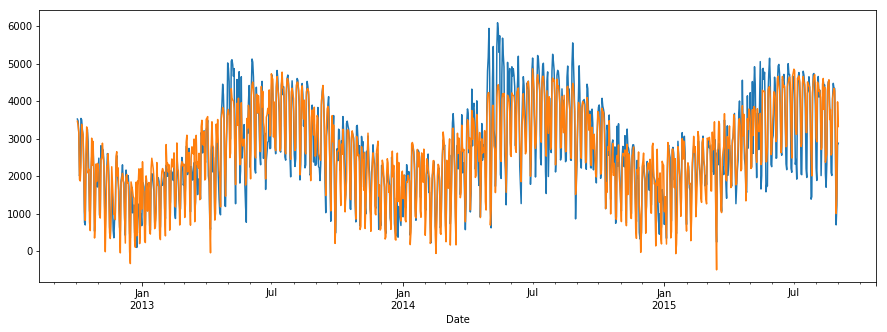

In [127]:
fig, ax = plt.subplots(figsize=(15, 5))
y.plot(ax=ax);
pd.Series(y_pred, index=y.index).plot(ax=ax);